In [ ]:
import xgboost as xbg
from xgboost import XGBClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import sys
import os
import os.path
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

%matplotlib inline

## DATAFRAME

In [ ]:
df1 = pd.read_csv('/home/ubuntu/Notebooks/terror2.csv')
df_num = df1.select_dtypes(include = ['number'])
df_num = df_num.fillna(0)
df_num = df_num.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','eventid','reset_index',
           'count_year_max','targetone','targettwo','targetoneone','targettwoone','targetonetwo','targettwotwo'], axis = 1)

dX = df_num.drop(['t1_year_f1','t2_year_f1','t1_20_f1','t2_20_f1','t1_year_f2','t2_year_f2',
                't1_20_f2', 't2_20_f2'], axis=1)

X_train = dX[dX.iyear < 2010]
X_test = dX[dX.iyear >= 2010]
y_train = df_num[df_num.iyear < 2010]['t2_year_f2']
y_test =  df_num[df_num.iyear >= 2010]['t2_year_f2']

## EVALUATION FUNCTIONS

In [114]:
def r_curve(y_score):
    fpr, tpr,_ = roc_curve(y_test, y_score, pos_label = 1)
    roc_auc = auc(fpr, tpr)

    print('Model: GBT')
    print('AUC: ' + str(roc_auc))
    print("")

    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], '--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('GBT')
    
def pr_curve(y_test, digit_prec=2):
    threshvec = np.unique(np.round(y_test,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(y_test[y_test>=thresh])
        fpvec[i] = sum(1-y_test[y_test>=thresh])
        fnvec[i] = sum(y_test[y_test<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec)
    plt.axis([0, 1, 0, 1])
    plt.xlabel("Precision")
    plt.ylabel("Recall")

## ALL MODELS, BASE PERFORMANCE

In [8]:
est = GradientBoostingClassifier(n_estimators=500).fit(X_train, y_train)
print( 'gbc = {0}'.format(est.score(X_test, y_test)))
y_predict_est = est.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_est, average='binary'))
y_score_est = est.predict_proba(X_test)[:,1]

gbc = 0.7154742901368936
(0.27937649880095922, 0.04225607544432354, 0.07340894770006301, None)


In [9]:
logr = LogisticRegression(penalty =  'l2', solver = 'liblinear').fit(X_train, y_train)
print( 'gbc = {0}'.format(logr.score(X_test, y_test)))
y_predict_logr = logr.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_logr, average='binary'))
y_score_logr = logr.predict_proba(X_test)[:,1]

gbc = 0.7333720311517439
(1.0, 0.00036271309394269132, 0.00072516316171138497, None)


In [10]:
# svc = SVC().fit(X_train, y_train)
# print( 'gbc = {0}'.format(svc.score(X_test, y_test)))
# y_predict_svc = svc.predict(X_test)
# print (precision_recall_fscore_support(y_test,y_predict_svc, average='binary'))
# # y_score_svc = svc.predict_proba(X_test)[:,1]

In [11]:
knn = KNeighborsClassifier().fit(X_train, y_train)
print( 'gbc = {0}'.format(knn.score(X_test, y_test)))
y_predict_knn = knn.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_knn, average='binary'))
y_score_knn = knn.predict_proba(X_test)[:,1]

gbc = 0.7022686596043148
(0.38433778419343195, 0.19314472252448314, 0.25709112854556426, None)


## GRAPHS OF RESULTS

Gradient Boosted Trees

Model: GBT
AUC: 0.499762881011



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


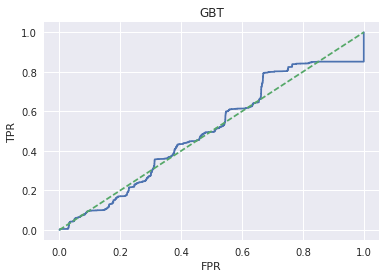

In [12]:
r_curve(y_score_est)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


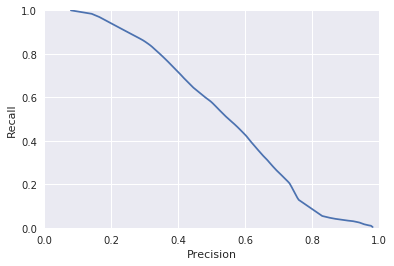

In [13]:
pr_curve(y_score_est)

Logistic Regression

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Model: GBT
AUC: 0.668372810774



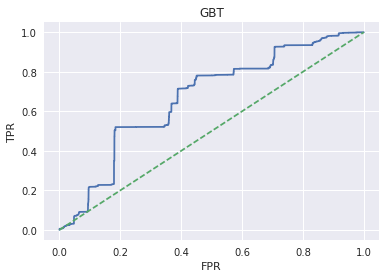

In [14]:
r_curve(y_score_logr)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


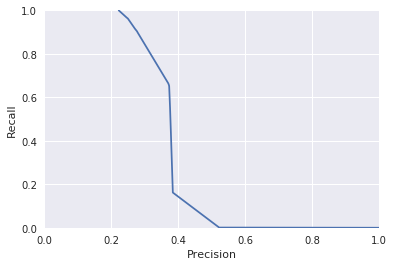

In [15]:
pr_curve(y_score_logr)

K-Nearest Neighbors

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Model: GBT
AUC: 0.542689409799



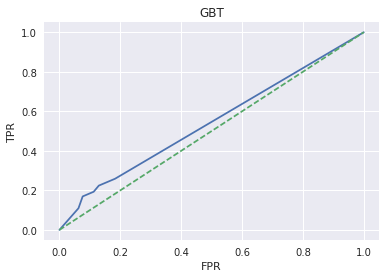

In [16]:
r_curve(y_score_knn)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


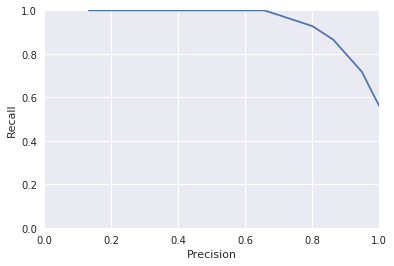

In [17]:
pr_curve(y_score_knn)

## FEATURE IMPORTANCES

Gradient Boosted Trees

In [18]:
sorted(zip(X_train.columns,abs(est.feature_importances_)), key=lambda x: -x[1])

[('current_year_count', 0.098639344839094922),
 ('iyear', 0.090464455659629184),
 ('tempone', 0.073781800834171934),
 ('temptwo', 0.071336505422881946),
 ('count_year_max_unbias', 0.069359150403919947),
 ('tempthree', 0.068639586568726055),
 ('diffone', 0.064541852467013522),
 ('difftwo', 0.058915171808899172),
 ('countone', 0.054163979080787614),
 ('counttwo', 0.049790292589771051),
 ('countfour', 0.041781446602836066),
 ('countthree', 0.03499153905820377),
 ('tempfour', 0.032496127267142266),
 ('ingroup', 0.025192875316526774),
 ('perpo', 0.022365039942355457),
 ('country', 0.021188685295259919),
 ('perpo_new', 0.020706952343970936),
 ('longitude', 0.015722867131978194),
 ('region', 0.0129032625744506),
 ('tempdiffone', 0.010033069307899123),
 ('tempdifffour', 0.0077042386460451405),
 ('latitude', 0.0075500137927642669),
 ('tempdiffthree', 0.00721363900033064),
 ('tempdifftwo', 0.006042226130341985),
 ('avgtempunc', 0.0037459471517044883),
 ('current_month_count', 0.00362042003858109

Logistic Regression

In [19]:
sorted(zip(X_train.columns,abs(logr.coef_[0])), key=lambda x: -x[1])

[('iyear', 0.00021059887864891146),
 ('ingroup', 5.7739788849397978e-05),
 ('count_year_max_unbias', 2.9331798576440134e-05),
 ('current_year_count', 2.1866377721609352e-05),
 ('country', 1.7726623159616644e-05),
 ('perpo', 1.7497124899890108e-05),
 ('perpo_new', 1.7496763060154895e-05),
 ('countone', 1.5839720902920067e-05),
 ('countthree', 1.4826277329314983e-05),
 ('counttwo', 1.4666506726190467e-05),
 ('natlty1', 1.4566787032096693e-05),
 ('countfour', 1.2240050569412686e-05),
 ('difftwo', 6.6397327867992275e-06),
 ('diffone', 5.5309325280073049e-06),
 ('longitude', 5.384627176728874e-06),
 ('ransomamtus', 4.9912813029380069e-06),
 ('targsubtype1', 4.5665306628506225e-06),
 ('current_month_count', 2.6884152818143961e-06),
 ('latitude', 2.5462727585368556e-06),
 ('avgtemp', 2.010469778099157e-06),
 ('tempone', 1.6473919181861281e-06),
 ('iday', 1.6270610209253053e-06),
 ('tempfour', 1.6086363514163717e-06),
 ('temptwo', 1.5961205055094592e-06),
 ('tempthree', 1.5532478358110567e-06)

In [20]:
# sorted(zip(X_train.columns,abs(knn.feature_importances_)), key=lambda x: -x[1])

## DROPPING FEATURES

In [22]:
col = X_train.columns.tolist()
[x for x in zip(*sorted(zip(X_train.columns,abs(est.feature_importances_)), key=lambda x: -x[1]))][0]

('current_year_count',
 'iyear',
 'tempone',
 'temptwo',
 'count_year_max_unbias',
 'tempthree',
 'diffone',
 'difftwo',
 'countone',
 'counttwo',
 'countfour',
 'countthree',
 'tempfour',
 'ingroup',
 'perpo',
 'country',
 'perpo_new',
 'longitude',
 'region',
 'tempdiffone',
 'tempdifffour',
 'latitude',
 'tempdiffthree',
 'tempdifftwo',
 'avgtempunc',
 'current_month_count',
 't2_year',
 'natlty1',
 'nreleased',
 'avgtemp',
 'targsubtype3',
 'month_alt',
 'ransomamt',
 'INT_LOG',
 'nkillter',
 'nkill',
 'iday',
 'propvalue',
 'nperps',
 'crit2',
 'nperpcap',
 'multiple',
 'specificity',
 'nwound',
 'ingroup3',
 'alternative',
 'imonth',
 't2_20',
 'ransom',
 'targtype3',
 'INT_IDEO',
 't1_year',
 'INT_MISC',
 'attacktype2',
 'targsubtype2',
 'claimed',
 'claimmode',
 'targtype2',
 'targtype1',
 'INT_ANY',
 'targsubtype1',
 'property',
 'weapsubtype1',
 't1_20',
 'extended',
 'vicinity',
 'crit1',
 'crit3',
 'doubtterr',
 'success',
 'suicide',
 'attacktype1',
 'attacktype3',
 'natlt

In [23]:
def dropping(df):
    return df.drop(['targtype1',
 'extended',
 'vicinity',
 'crit1',
 'crit3',
 'doubtterr',
 'success',
 'suicide',
 'attacktype1',
 'attacktype3',
 'targtype2',
 'targsubtype2',
 'natlty3',
 'ingroup2',
 'guncertain1',
 'guncertain2',
 'guncertain3',
 'claim2',
 'claimmode2',
 'claim3',
 'claimmode3',
 'compclaim',
 'weaptype1',
 'weaptype2',
 'weapsubtype2',
 'weaptype3',
 'weapsubtype3',
 'weaptype4',
 'weapsubtype4',
 'nkillus',
 'nwoundus',
 'nwoundte',
 'property',
 'propextent',
 'nhostkidus',
 'nhours',
 'ndays',
 'ransomamtus',
 'ransompaid',
 'ransompaidus'], axis = 1)

X_train = dropping(X_train)
X_test = dropping(X_test)

# Running Models

In [25]:
est = GradientBoostingClassifier(n_estimators=500).fit(X_train, y_train)
print( 'gbc = {0}'.format(est.score(X_test, y_test)))
y_predict_est = est.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_est, average='binary'))
y_score_est = est.predict_proba(X_test)[:,1]

gbc = 0.7198277947080733
(0.31216216216216214, 0.041893362350380846, 0.073872721458266719, None)


In [26]:
logr = LogisticRegression(penalty =  'l2', solver = 'liblinear').fit(X_train, y_train)
print( 'gbc = {0}'.format(logr.score(X_test, y_test)))
y_predict_logr = logr.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_logr, average='binary'))
y_score_logr = logr.predict_proba(X_test)[:,1]

gbc = 0.7311952788661539
(0.12280701754385964, 0.0012694958287994198, 0.0025130138215760187, None)


In [27]:
# svc = SVC().fit(X_train, y_train)
# print( 'gbc = {0}'.format(svc.score(X_test, y_test)))
# y_predict_svc = svc.predict(X_test)
# print (precision_recall_fscore_support(y_test,y_predict_svc, average='binary'))
# # y_score_svc = svc.predict_proba(X_test)[:,1]

In [28]:
knn = KNeighborsClassifier().fit(X_train, y_train)
print( 'gbc = {0}'.format(knn.score(X_test, y_test)))
y_predict_knn = knn.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_knn, average='binary'))
y_score_knn = knn.predict_proba(X_test)[:,1]

gbc = 0.7202147728921782
(0.44560838033843675, 0.2005803409503083, 0.27663831915957976, None)


# Dropping More Features

In [29]:
[x for x in zip(*sorted(zip(X_train.columns,abs(est.feature_importances_)), key=lambda x: -x[1]))][0]

('current_year_count',
 'iyear',
 'tempone',
 'temptwo',
 'count_year_max_unbias',
 'tempthree',
 'diffone',
 'difftwo',
 'countone',
 'counttwo',
 'countfour',
 'countthree',
 'tempfour',
 'ingroup',
 'perpo_new',
 'perpo',
 'country',
 'longitude',
 'region',
 'tempdiffone',
 'tempdifffour',
 'latitude',
 'tempdiffthree',
 'tempdifftwo',
 'current_month_count',
 'avgtempunc',
 't2_year',
 'natlty1',
 'nreleased',
 'avgtemp',
 'targsubtype3',
 'month_alt',
 'ransomamt',
 'INT_LOG',
 'nkillter',
 'propvalue',
 'nperps',
 'nkill',
 'crit2',
 'nperpcap',
 't2_20',
 'multiple',
 'imonth',
 'specificity',
 'nwound',
 'ingroup3',
 'alternative',
 'claimed',
 'ransom',
 'iday',
 'INT_IDEO',
 'targsubtype1',
 'INT_MISC',
 't1_year',
 'attacktype2',
 'claimmode',
 'weapsubtype1',
 'INT_ANY',
 'targtype3',
 'natlty2',
 'ishostkid',
 'nhostkid',
 'hostkidoutcome',
 't1_20')

In [30]:
def dropping_two(df):
    return df.drop(['nkillter',
 'propvalue',
 'nperps',
 'nkill',
 'crit2',
 'nperpcap',
 'iday',
 'multiple',
 'specificity',
 't2_20',
 'nwound',
 'imonth',
 'ingroup3',
 'alternative',
 'claimed',
 'ransom',
 'INT_IDEO',
 'INT_MISC',
 't1_year',
 'attacktype2',
 'targtype3',
 'claimmode',
 'targsubtype1',
 'weapsubtype1',
 't1_20',
 'natlty2',
 'ishostkid',
 'nhostkid',
 'hostkidoutcome',
 'INT_ANY'], axis = 1)

X_test = dropping_two(X_test)
X_train = dropping_two(X_train)

# Running Models

In [32]:
est = GradientBoostingClassifier(n_estimators=500).fit(X_train, y_train)
print( 'gbc = {0}'.format(est.score(X_test, y_test)))
y_predict_est = est.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_est, average='binary'))
y_score_est = est.predict_proba(X_test)[:,1]

gbc = 0.7162482465051033
(0.28795180722891567, 0.043344214726151617, 0.075346784363177807, None)


In [33]:
logr = LogisticRegression(penalty =  'l2', solver = 'liblinear').fit(X_train, y_train)
print( 'gbc = {0}'.format(logr.score(X_test, y_test)))
y_predict_logr = logr.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_logr, average='binary'))
y_score_logr = logr.predict_proba(X_test)[:,1]

gbc = 0.7332752866057176
(0.0, 0.0, 0.0, None)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
svc = SVC().fit(X_train, y_train)
print( 'gbc = {0}'.format(svc.score(X_test, y_test)))
y_predict_svc = svc.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_svc, average='binary'))
# y_score_svc = svc.predict_proba(X_test)[:,1]

gbc = 0.7332752866057176
(0.0, 0.0, 0.0, None)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
knn = KNeighborsClassifier().fit(X_train, y_train)
print( 'gbc = {0}'.format(knn.score(X_test, y_test)))
y_predict_knn = knn.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_knn, average='binary'))
y_score_knn = knn.predict_proba(X_test)[:,1]

gbc = 0.7147003337686838
(0.42059553349875928, 0.18443960826985853, 0.25642965204236007, None)


## REMOVING DATA FROM BEFORE 1990

In [163]:
df = pd.read_csv('/home/ubuntu/Notebooks/terror2.csv')
df_num = df.select_dtypes(include = ['number'])
df_num = df_num.fillna(0)
df_num = df_num.drop(['Unnamed: 0','eventid','reset_index',
           'count_year_max','targetone','targettwo','targetoneone','targettwoone','targetonetwo','targettwotwo'], axis = 1)

dX = df_num.drop(['t1_year_f1','t2_year_f1','t1_20_f1','t2_20_f1','t1_year_f2','t2_year_f2',
                't1_20_f2', 't2_20_f2'], axis=1)

X_train = dX[(dX.iyear <= 2010) & (dX.iyear >= 1990)]
X_test = dX[dX.iyear > 2010]

y_train = df_num[(df_num.iyear <= 2010) & (df_num.iyear >= 1990)]['t2_year_f2']
y_test =  df_num[df_num.iyear > 2010]['t2_year_f2']

y_train.value_counts()

0.0    20118
1.0     4102
Name: t2_year_f2, dtype: int64

In [11]:
def dropping(df):
    return df.drop(['targtype1',
 'extended',
 'vicinity',
 'crit1',
 'crit3',
 'doubtterr',
 'success',
 'suicide',
 'attacktype1',
 'attacktype3',
 'targtype2',
 'targsubtype2',
 'natlty3',
 'ingroup2',
 'guncertain1',
 'guncertain2',
 'guncertain3',
 'claim2',
 'claimmode2',
 'claim3',
 'claimmode3',
 'compclaim',
 'weaptype1',
 'weaptype2',
 'weapsubtype2',
 'weaptype3',
 'weapsubtype3',
 'weaptype4',
 'weapsubtype4',
 'nkillus',
 'nwoundus',
 'nwoundte',
 'property',
 'propextent',
 'nhostkidus',
 'nhours',
 'ndays',
 'ransomamtus',
 'ransompaid',
 'ransompaidus'], axis = 1)

X_train = dropping(X_train)
X_test = dropping(X_test)

# Running Models

In [67]:
est = GradientBoostingClassifier(n_estimators=500).fit(X_train, y_train)
print( 'gbc = {0}'.format(est.score(X_test, y_test)))
y_predict_est = est.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_est, average='binary'))
y_score_est = est.predict_proba(X_test)[:,1]

gbc = 0.7086281550322103
(0.45220273738237809, 0.91457612456747406, 0.60518030910131659, None)


In [97]:
est = GradientBoostingClassifier(n_estimators=500).fit(X_train, y_train)
print( 'gbc = {0}'.format(est.score(X_test, y_test)))
y_predict_est = est.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_est, average='binary'))
y_score_est = est.predict_proba(X_test)[:,1]

gbc = 0.6737247861442602
(0.42202386922074014, 0.91003460207612452, 0.57663583418979103, None)


In [98]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_predict_est, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.95      0.60      0.73     14314
    class 1       0.42      0.91      0.58      4624

avg / total       0.82      0.67      0.70     18938



In [101]:
# y_test_probabilities has shape = [n_samples, n_classes]
y_test_probabilities = est.predict_proba(X_test)
y_test_predictions_high_precision = y_test_probabilities[:,1] > 0.8
y_test_predictions_high_recall = y_test_probabilities[:,1] > 0.1
print(classification_report(y_test, y_test_predictions_high_recall, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.94      0.28      0.44     14314
    class 1       0.30      0.94      0.45      4624

avg / total       0.78      0.44      0.44     18938



In [68]:
logr = LogisticRegression(penalty =  'l2', solver = 'liblinear').fit(X_train, y_train)
print( 'gbc = {0}'.format(logr.score(X_test, y_test)))
y_predict_logr = logr.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_logr, average='binary'))
y_score_logr = logr.predict_proba(X_test)[:,1]

gbc = 0.7047734713274897
(0.10722989439480098, 0.028546712802768166, 0.045089666951323652, None)


In [18]:
svc = SVC(kernel = 'rbf').fit(X_train, y_train)
print( 'gbc = {0}'.format(svc.score(X_test, y_test)))
y_predict_svc = svc.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_svc, average='binary'))
# y_score_svc = svc.predict_proba(X_test)[:,1]

gbc = 0.755834829443447
(0.0, 0.0, 0.0, None)


/Users/toni/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
knn = KNeighborsClassifier().fit(X_train, y_train)
print( 'gbc = {0}'.format(knn.score(X_test, y_test)))
y_predict_knn = knn.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_knn, average='binary'))
y_score_knn = knn.predict_proba(X_test)[:,1]

gbc = 0.7634385890801563
(0.52369980250164583, 0.34407439446366783, 0.41529626729313496, None)


In [125]:
est = GradientBoostingClassifier(n_estimators=500).fit(X_train, y_train)
print( 'gbc = {0}'.format(est.score(X_test, y_test)))
y_predict_est = est.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_est, average='binary'))
y_score_est = est.predict_proba(X_test)[:,1]

gbc = 0.6729855317351358
(0.42147933139825844, 0.91068339100346019, 0.57625726992815596, None)


In [127]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_predict_est, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.95      0.60      0.73     14314
    class 1       0.42      0.91      0.58      4624

avg / total       0.82      0.67      0.70     18938



In [129]:
# y_test_probabilities has shape = [n_samples, n_classes]
y_test_probabilities = est.predict_proba(X_test)
y_test_predictions_high_precision = y_test_probabilities[:,1] > 0.8
y_test_predictions_high_recall = y_test_probabilities[:,1] > 0.1

target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_test_predictions_high_recall, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.93      0.27      0.42     14314
    class 1       0.29      0.93      0.45      4624

avg / total       0.77      0.43      0.43     18938



Model: GBT
AUC: 0.753441457972



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


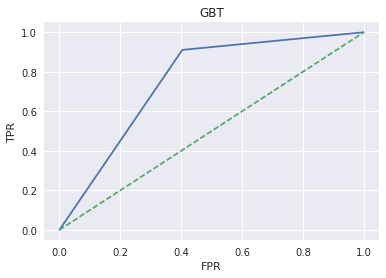

In [130]:
r_curve(y_predict_est)

Model: GBT
AUC: 0.602904190879



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


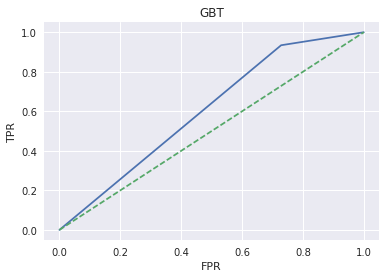

In [131]:
r_curve(y_test_predictions_high_recall)

# GridSearchCV: XGBOOST & KNN

In [ ]:
p_xgb = {'learning_rate':[.005,.05,.07,.1],'subsample':[.65,.75,.85],'n_estimators':[500,600,700,1500],'min_child_weight': [10, 12, 15, 20],'max_depth':[2,3,5]}
xgbc = XGBClassifier(nthread = -1, objective='binary:logistic')
xgbc_f1_grid = GridSearchCV(xgbc, p_xgb, scoring = 'roc_auc', verbose = 100)

grid = xgbc_f1_grid.fit(X_train,y_train)

In [35]:
p_knn = {'n_neighbors':[4,5,6,7,8],'p':[1,2]}
knn = KNeighborsClassifier(n_jobs=-1)
knn_f1_grid = GridSearchCV(knn, p_knn, scoring = 'roc_auc')

knngrid = knn_f1_grid.fit(X_train, y_train)
knngrid.best_params_

{'n_neighbors': 4, 'p': 1}

In [179]:
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors = 4, p = 1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

In [180]:
knn.score(X_test, y_test)

0.61183863132326544

In [181]:
kpred = knn.predict(X_test)
print (precision_recall_fscore_support(y_test,kpred, average='binary'))
kp = knn.predict_proba(X_test)[:,1]

(0.3757857338070511, 0.89208477508650519, 0.52881225562463952, None)


In [182]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, kpred, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.94      0.52      0.67     14314
    class 1       0.38      0.89      0.53      4624

avg / total       0.80      0.61      0.64     18938



Model: GBT
AUC: 0.706696292811



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


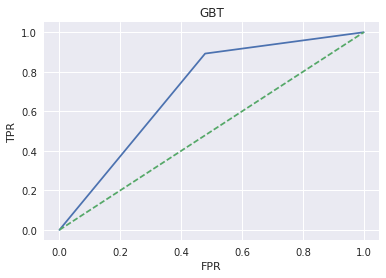

In [183]:
r_curve(kpred)

In [184]:
# y_test_probabilities has shape = [n_samples, n_classes]
y_test_probabilities = knn.predict_proba(X_test)
y_test_predictions_high_precision = y_test_probabilities[:,1] > 0.8
y_test_predictions_high_recall = y_test_probabilities[:,1] > 0.1

In [185]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_test_predictions_high_recall, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.97      0.39      0.56     14314
    class 1       0.34      0.96      0.50      4624

avg / total       0.81      0.53      0.54     18938



Model: GBT
AUC: 0.697114712869



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


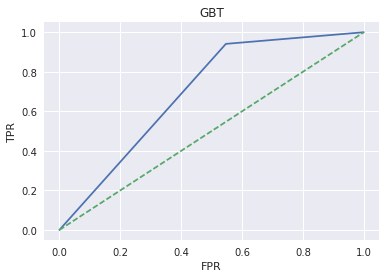

In [234]:
r_curve(y_test_predictions_high_recall)

# Normalizing DF

In [164]:
normalized_X_train = X_train.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
normalized_X_test = X_test.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [54]:
p_knn = {'n_neighbors':[4,5,6,7,8],'p':[1,2]}
knn = KNeighborsClassifier(n_jobs=-1)
knn_f1_grid = GridSearchCV(knn, p_knn, scoring = 'roc_auc')
knngrid = knn_f1_grid.fit(normalized_X_train, y_train)
knngrid.best_params_

{'n_neighbors': 8, 'p': 1}

In [9]:
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors = 8, p = 1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

In [10]:
knn.score(X_test,y_test)

0.60882880980040133

In [11]:
kpred = knn.predict(X_test)
print (precision_recall_fscore_support(y_test,kpred, average='binary'))
kp = knn.predict_proba(X_test)[:,1]

(0.37461718609259592, 0.89943771626297575, 0.52893297723515198, None)


In [15]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, kpred, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.94      0.51      0.67     14314
    class 1       0.37      0.90      0.53      4624

avg / total       0.80      0.61      0.63     18938



In [17]:
y_test_probabilities = knn.predict_proba(X_test)
y_test_predictions_high_precision = y_test_probabilities[:,1] > 0.8
y_test_predictions_high_recall = y_test_probabilities[:,1] > 0.1

target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_test_predictions_high_recall, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.97      0.33      0.49     14314
    class 1       0.32      0.97      0.48      4624

avg / total       0.81      0.48      0.48     18938



In [82]:
df = pd.DataFrame({'a': y_test, 'p': y_test_predictions_high_recall, 'info':X_test.iyear, 'perpo_new':X_test.perpo_new})

def test(x):
    c = 0
    i = 0
    if x['a']==1.0 and x['p']==True:
        c+=1
    elif x['a']==0.0 and x['p']==True: 
        i+=1
    else:
        pass
    return c

sum(df[df['info'] == 2011].apply(lambda x: test(x), axis = 1 ))

833

In [84]:
df['add'] = df[df['info'] == 2011].apply(lambda x: test(x), axis = 1 )
df[df['add'] == 1].perpo_new.value_counts()

95     35
209    35
92     30
97     15
6       8
167     7
93      6
205     6
603     5
75      5
174     4
155     3
69      3
98      2
43      2
34      2
130     1
198     1
142     1
63      1
45      1
217     1
Name: perpo_new, dtype: int64

In [80]:
df[df['add'] == 1].perpo_new.value_counts()

95     35
209    35
92     30
97     15
6       8
167     7
93      6
205     6
603     5
75      5
174     4
155     3
69      3
98      2
43      2
34      2
130     1
198     1
142     1
63      1
45      1
217     1
Name: perpo_new, dtype: int64

Model: GBT
AUC: 0.707194057237



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


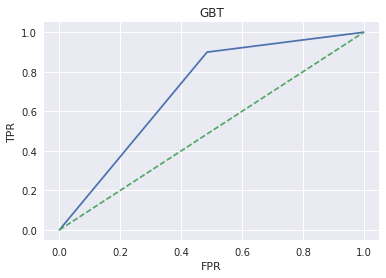

In [193]:
r_curve(kpred)

Model: GBT
AUC: 0.645406800418



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


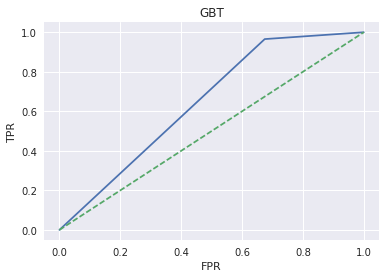

In [194]:
r_curve(y_test_predictions_high_recall)

# More XGBOOST Evaluation

In [195]:
best_xgbc = XGBClassifier(learning_rate=0.005, max_depth=3,min_child_weight=15, n_estimators=700, subsample=0.75,nthread = -1, objective='binary:logistic')
best_xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.005, max_delta_step=0, max_depth=3,
       min_child_weight=15, missing=None, n_estimators=700, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [196]:
best_xgbc.score(X_test, y_test)

0.75583482944344704

In [197]:
y_predict_bestx = best_xgbc.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_bestx, average='binary'))
y_score_x = best_xgbc.predict_proba(X_test)[:,1]

(0.5, 0.32417820069204151, 0.39333508265547101, None)


In [198]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_predict_bestx, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.80      0.90      0.85     14314
    class 1       0.50      0.32      0.39      4624

avg / total       0.73      0.76      0.74     18938



In [200]:
y_test_probabilities = best_xgbc.predict_proba(X_test)
y_test_predictions_high_precision = y_test_probabilities[:,1] > 0.8
y_test_predictions_high_recall = y_test_probabilities[:,1] > 0.1

target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_test_predictions_high_recall, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.96      0.43      0.59     14314
    class 1       0.35      0.94      0.51      4624

avg / total       0.81      0.55      0.57     18938



Model: GBT
AUC: 0.609727775769



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


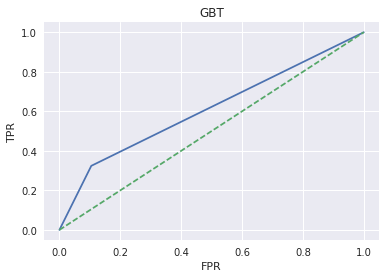

In [201]:
r_curve(y_predict_bestx)

Model: GBT
AUC: 0.684717604731



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


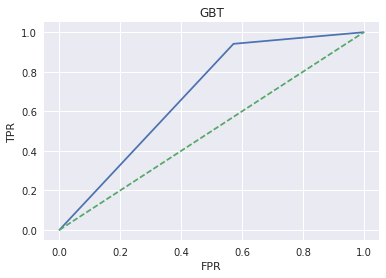

In [202]:
r_curve(y_test_predictions_high_recall)

In [204]:
best_xgbc = XGBClassifier(nthread = -1, objective='binary:logistic',learning_rate=0.005, max_depth=3, min_child_weight=12, n_estimators=700, subsample=0.75)
best_xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.005, max_delta_step=0, max_depth=3,
       min_child_weight=12, missing=None, n_estimators=700, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [205]:
best_xgbc.score(X_test, y_test)

0.78931249339951426

In [206]:
y_predict_bestx = best_xgbc.predict(X_test)
print (precision_recall_fscore_support(y_test,y_predict_bestx, average='binary'))
y_score_x = best_xgbc.predict_proba(X_test)[:,1]

(0.58761746821448313, 0.45977508650519033, 0.51589420043678724, None)


In [207]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_predict_bestx, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.84      0.90      0.87     14314
    class 1       0.59      0.46      0.52      4624

avg / total       0.78      0.79      0.78     18938



In [209]:
y_test_probabilities = best_xgbc.predict_proba(X_test)
y_test_predictions_high_precision = y_test_probabilities[:,1] > 0.8
y_test_predictions_high_recall = y_test_probabilities[:,1] > 0.1

target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_test_predictions_high_recall, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.96      0.45      0.62     14314
    class 1       0.36      0.94      0.52      4624

avg / total       0.81      0.57      0.59     18938



Model: GBT
AUC: 0.677770734534



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


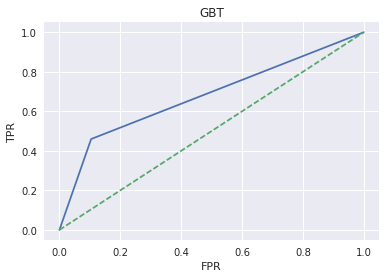

In [210]:
r_curve(y_predict_bestx)

Model: GBT
AUC: 0.69729270603



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


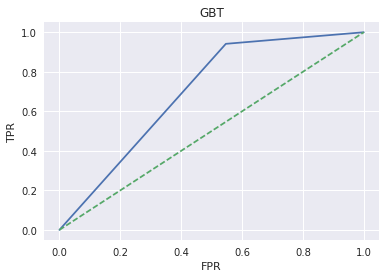

In [211]:
r_curve(y_test_predictions_high_recall)